In [1]:
import netCDF4
import numpy as np
import tensorflow as tf

# Load the samples from your files
with netCDF4.Dataset("out50km.nc", 'r') as ds:
    samples_lr = np.array(ds["TOT_PREC"][:], copy=False)

with netCDF4.Dataset("out12km.nc", 'r') as ds:
    samples_hr = np.array(ds["TOT_PREC"][:], copy=False)

# convert missing data to zeros
samples_lr[~np.isfinite(samples_lr)] = 0
samples_hr[~np.isfinite(samples_hr)] = 0

# Do a log-transformation to reduce dynamic range.
# We threshold data to 0.1 mm/h and set everything below to 0.02 mm/h
# to allow the log-transformation to work.
samples_lr[samples_lr < 0.1] = 0.02 
samples_hr[samples_hr < 0.1] = 0.02 
samples_lr = np.log10(samples_lr)
samples_hr = np.log10(samples_hr)

# Add an extra dimension to represent the single channel
samples_lr = samples_lr[..., np.newaxis]
samples_hr = samples_hr[..., np.newaxis]

# Crop the images
crop_dims_lr = (108, 108)  # This is a square shape that is a multiple of 4
crop_dims_hr = tuple(4*dim for dim in crop_dims_lr)

samples_lr = samples_lr[:, :crop_dims_lr[0], :crop_dims_lr[1]]
samples_hr = samples_hr[:, :crop_dims_hr[0], :crop_dims_hr[1]]

# set aside 10% of data for testing (not used to train model)
indices = np.arange(samples_hr.shape[0])
rng = np.random.RandomState(seed=1)
rng.shuffle(indices)
N_testing = int(samples_hr.shape[0]*0.1)
samples_hr_test = samples_hr[indices[:N_testing],...]
samples_hr = samples_hr[indices[N_testing:],...]

samples_lr_test = samples_lr[indices[:N_testing],...]
samples_lr = samples_lr[indices[N_testing:],...]

# create TensorFlow Dataset for training
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((samples_lr, samples_hr))
dataset = dataset.shuffle(buffer_size=256).batch(batch_size)

print(samples_lr.shape)
print(samples_hr.shape)

2023-07-07 11:13:54.290505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-07 11:13:54.355137: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-07 11:13:54.356409: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 11:13:55.170498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(649, 108, 108, 1)
(649, 432, 432, 1)


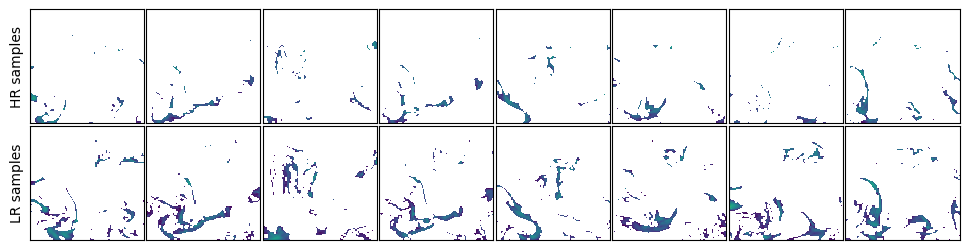

In [2]:
from matplotlib import colors, gridspec, pyplot as plt

def plot_precip(ax, logR):
    """ Plot a single precipitation image.
    """
    if logR.ndim == 3:
        logR = logR[:,:,0] # remove channels dimension
    R = 10**logR
    R[R < 0.1] = np.nan
    ax.imshow(R, norm=colors.LogNorm(0.1,100,clip=True))
    ax.tick_params(left=False, bottom=False,
        labelleft=False, labelbottom=False)  

def plot_samples(samples, labels=None):
    """ Plot a grid with many images.
    """
    N_variables = len(samples)
    N_samples = len(samples[0])
    fig = plt.figure(figsize=(N_samples*1.5, N_variables*1.5))
    gs = gridspec.GridSpec(N_variables, N_samples, hspace=0.02, wspace=0.02)

    for (i,variable) in enumerate(samples):
        for (j,sample) in enumerate(variable):
            ax = fig.add_subplot(gs[i,j])
            plot_precip(ax, sample)
            if (j == 0) and (labels is not None):
                ax.set_ylabel(labels[i])

    fig.show()
# Show a selection of interesting samples from the test set
#indices = [2,5,14,16,17,19,28,37]

# Uncomment to use a random selection (change seed for a different selection):
rng = np.random.RandomState(seed=4)
indices = rng.choice(samples_hr_test.shape[0], 8, replace=False)

plot_samples(
    [samples_hr_test[indices,...], samples_lr_test[indices,...]],
    labels=["HR samples", "LR samples"]
)

In [3]:
print(samples_lr.shape)
print(samples_hr.shape)

(649, 108, 108, 1)
(649, 432, 432, 1)


In [4]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Concatenate, Conv2D, Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, UpSampling2D


def create_generator(
    block_widths=(256,128),
    input_shape=(108,108,1), 
    noise_shape=(108,108,8)  
):
    # inputs (concatenated)
    input_lr = Input(shape=input_shape)
    input_noise = Input(shape=noise_shape)
    x = Concatenate()([input_lr, input_noise])

    x = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same'
    )(x)
    x = LeakyReLU(0.2)(x)
    # upsampling stages
    for width in block_widths:
        x = UpSampling2D(interpolation='bilinear')(x)
        x = Conv2D(
            width, kernel_size=(3,3), padding='same'
        )(x)
        x = LeakyReLU(0.2)(x)

    # final projection to output space
    output = Conv2D(1, kernel_size=(1,1))(x)

    return Model(inputs=[input_lr, input_noise], outputs=output)


def create_discriminator(
    block_widths=(64,128,256),
    input_shape_hr=(432,432,1),
    input_shape_lr=(108,108,1),
    postproc_convs=2,
    output_activation='linear' # 'linear' when using 'from_logits' in loss
):
    # inputs
    input_hr = Input(shape=input_shape_hr)
    input_lr = Input(shape=input_shape_lr)
    
    # Convolution steps for both HR and LR inputs
    x_hr = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same', activation='relu'
    )(input_hr)
    x_hr = LeakyReLU(0.2)(x_hr)
    x_lr = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same', activation='relu'
    )(input_lr)  # change x_lr to input_lr
    x_lr = LeakyReLU(0.2)(x_lr)

    # Downsample HR samples twice, and process LR samples normally
    for i, width in enumerate(block_widths):
        if i < 2:  # only downsample HR twice
            x_hr = Conv2D(
                width, kernel_size=(3,3), padding='same', strides=2,
            )(x_hr)
            x_hr = LeakyReLU(0.2)(x_hr)
        
        x_lr = Conv2D(
            width, kernel_size=(3,3), padding='same',
        )(x_lr)
        x_lr = LeakyReLU(0.2)(x_lr)

    # Concatenate HR and LR branches and do some joint processing
    x = Concatenate()([x_hr, x_lr])
    for _ in range(postproc_convs):
        x = Conv2D(block_widths[-1], kernel_size=(3,3), padding='same')(x)
        x = LeakyReLU(0.2)(x)

    # Pool to get outputs
    x = GlobalAveragePooling2D()(x)
    output = Dense(1, activation=output_activation)(x)

    return Model(inputs=[input_lr, input_hr], outputs=output)

generator = create_generator()
discriminator = create_discriminator()

In [5]:
# Print summaries of the model
generator.summary()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 108, 108, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 108, 108, 8  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 108, 108, 9)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [6]:
class DownscalingGAN(Model):
    def __init__(self, discriminator, generator, noise_shape=(108, 108, 8)): # Adjusted to match the shape of your low-resolution data
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_shape = noise_shape
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.step_number = tf.Variable(0)

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        (samples_lr, samples_hr) = data

        # Sample noise for the generator.
        batch_size = tf.shape(samples_hr)[0]
        noise = tf.random.normal(
            shape=(batch_size,)+self.noise_shape
        )

        def train_discriminator():
            # Generate fake samples.
            samples_gen = self.generator([samples_lr, noise])

            # Combine them with real images.
            combined_samples_hr = tf.concat([samples_gen, samples_hr], axis=0)
            combined_samples_lr = tf.concat([samples_lr, samples_lr], axis=0)

            # Assemble labels discriminating real from fake images.
            labels = tf.concat(
                [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            )

            # Train the discriminator.
            with tf.GradientTape() as tape:
                predictions = self.discriminator(
                    [combined_samples_lr, combined_samples_hr]
                )
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

            # Monitor loss.
            self.disc_loss_tracker.update_state(d_loss)

        def train_generator():
            # Create labels that say "all real images".
            misleading_labels = tf.zeros((batch_size, 1))

            # Train the generator (note that we should *not* update the weights
            # of the discriminator)!
            with tf.GradientTape() as tape:
                samples_gen = self.generator([samples_lr, noise])
                predictions = self.discriminator([samples_lr, samples_gen])
                g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(
                zip(grads, self.generator.trainable_weights)
            )

            # Monitor loss.
            self.gen_loss_tracker.update_state(g_loss)
        
        # If we trained the generator now, train the discriminator next
        # or vice versa.
        
        tf.cond(
            self.step_number % 4 != 3,
            train_generator,
            train_discriminator
        )        
        self.step_number.assign(self.step_number+1)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

gan = DownscalingGAN(discriminator, generator)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    g_optimizer=keras.optimizers.Adam(learning_rate=12e-4),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [7]:
#gan.fit(dataset, epochs=1)

In [ ]:
from tensorflow.keras.callbacks import Callback
#from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
#early_stopping_callback = EarlyStopping(monitor='g_loss', patience=10, verbose=1)

class PlotCallback(Callback):
    def __init__(self, generator, samples_lr_test, samples_hr_test, indices, plot_every=5):
        self.generator = generator
        self.samples_lr_test = samples_lr_test
        self.samples_test = samples_hr_test
        self.indices = indices
        self.plot_every = plot_every
        self.g_losses = []
        self.d_losses = []
        self.rng = np.random.RandomState(seed=15)

    def on_epoch_end(self, epoch, logs={}):
        self.g_losses.append(logs.get('g_loss'))
        self.d_losses.append(logs.get('d_loss'))

        if (epoch+1) % self.plot_every == 0:
            # Plot losses
            plt.figure(figsize=(10, 5))
            plt.plot(self.g_losses, label='Generator loss')
            plt.plot(self.d_losses, label='Discriminator loss')
            plt.title('Generator and Discriminator Loss During Training')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Generate samples
            noise = self.rng.randn(len(self.indices), 108, 108, 8)
            samples_gen_1 = self.generator.predict_on_batch(
                [self.samples_lr_test[self.indices,...], noise]
            )
            noise = self.rng.randn(len(self.indices), 108, 108, 8)
            samples_gen_2 = self.generator.predict_on_batch(
                [self.samples_lr_test[self.indices,...], noise]
            )
            plot_samples(
                [
                    self.samples_lr_test[self.indices,...], self.samples_test[self.indices,...], 
                    samples_gen_1, samples_gen_2    
                ],
                labels=["LR samples", "HR samples", "Gen. samples 1", "Gen. samples 2"]
            )

# Create callback
plot_callback = PlotCallback(generator, samples_lr_test, samples_hr_test, indices, plot_every=10)

# Fit the model with both callbacks
gan.fit(dataset, epochs=80, callbacks=[plot_callback])

# Save the generator and discriminator models
#generator.save('new_generator_model.h5')
#discriminator.save('new_discriminator_model.h5')

Epoch 1/80


2023-07-07 11:14:02.519844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [649,432,432,1]
	 [[{{node Placeholder/_1}}]]
2023-07-07 11:14:02.520178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [649,432,432,1]
	 [[{{node Placeholder/_1}}]]
2023-07-07 11:14:02.580446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'cond/zeros/packed/strided_slice' 

In [ ]:
rng = np.random.RandomState(seed=15)
num_samples = 8

# Selection of interesting samples from the test set
indices = [2,5,14,16,17,19,28,37]

# Uncomment to use a random selection (change seed for a different selection):
# indices = rng.choice(samples.shape[0], num_samples, replace=False)

noise = rng.randn(num_samples, 108, 108, 8)
samples_gen_1 = generator.predict_on_batch(
    [samples_lr_test[indices,...], noise]
)
noise = rng.randn(num_samples, 108, 108, 8)
samples_gen_2 = generator.predict_on_batch(
    [samples_lr_test[indices,...], noise]
)
plot_samples(
    [
        samples_lr_test[indices,...], samples_hr_test[indices,...], 
        samples_gen_1, samples_gen_2    
    ],
    labels=["LR samples", "HR samples", "Gen. samples 1", "Gen. samples 2"]
)

In [ ]:
# Save the generator and discriminator models
#generator.save('own_generator_model.h5')
#discriminator.save('own_discriminator_model.h5')